# Class Activation Mapping
This jupyter notebook implements the ideas of the paper https://arxiv.org/abs/1512.04150 which is from researches of MIT. The basic idea is, that a CNN learns activation maps as types of bounding boxes for free (without the need to label all bounding boxes by hand). 

<img src="architecture.png">

(Image copied from paper at  https://arxiv.org/abs/1512.04150)

## Steps to get the Class Activation Map (CAM)
(Prerequesite: CNN with Global Average Pooling layer after the last convolutional layer and NO additional dense layers (only the output dense layer for getting final predictions!)
1. Feed image to convolutional network and create perdiction
2. Fetch the weights connected to the winning neuron
3. Store the outputs from the last convolutional layer
4. Use the fetched weights to weight the corresponding output from last convolutional layer and add all values to one final map
5. Expand this final map (i.e. using bilinear upsampling) to the size of the input image and plot the results

## Dataset and Model
### Dataset
The used dataset can be found on Kaggel (https://www.kaggle.com/moltean/fruits). It's a dataset of 90483 images containing 131 different fruits and vegetables.

### Model


In [1]:
# necessary imports
import os
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

%matplotlib inline

In [2]:
# set parameters of images such that they fit to ResNet-50 model which was used for training
img_width, img_height = 224, 224
from google.colab import drive
drive.mount('/content/drive')
test_data_dir = '/content/drive/MyDrive/Data_challenge/test.csv'


Mounted at /content/drive


In [3]:
test_data = pd.read_csv(test_data_dir)
missing_image_name = 'AE00072_145326_00_1_2_2001.jpg'
print(test_data[test_data.images == missing_image_name])
test_data.drop(test_data.loc[test_data.images == missing_image_name].index, inplace=True)
print(test_data[test_data.images == missing_image_name])

                             images  labels
922  AE00072_145326_00_1_2_2001.jpg       0
Empty DataFrame
Columns: [images, labels]
Index: []


In [4]:
test_data.head()

,images,labels
0,AE00022_095817_00_1_1_2001.jpg,1
1,AE00382_081204_00_3_4_2001.jpg,1
2,AE00281_235123_00_2_1_2001.jpg,1
3,AE00408_051313_00_4_4_2001.jpg,0
4,AE00379_034020_00_1_2_2001.jpg,0


In [5]:
# pre-process test data such that it has same pre-processing as data used for training
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=15
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe (
    test_data,
    r"/content/drive/MyDrive/Data_challenge/x_test/", 
    x_col='images',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1988 validated image filenames.


In [6]:
# load pre-trained model
loaded_model = load_model(r'/content/drive/MyDrive/Data_challenge/models2/new-model-19-0.99.hdf5')

(15, 224, 224, 3)
AE00022_095817_00_1_1_2001.jpg
AE00382_081204_00_3_4_2001.jpg
AE00281_235123_00_2_1_2001.jpg
AE00408_051313_00_4_4_2001.jpg
AE00379_034020_00_1_2_2001.jpg
AE00343_113752_00_3_2_2001.jpg
AE00346_093109_00_3_4_2001.jpg
AE00476_191132_00_4_2_2001.jpg
AE00481_171036_00_1_1_2001.jpg
AE00191_171626_00_2_1_2001.jpg
AE00433_172202_00_1_3_2001.jpg
AE00389_103128_00_1_1_2001.jpg
AE00305_012956_00_1_4_2001.jpg
AE00453_161459_00_2_1_2001.jpg
AE00531_003449_00_1_1_2001.jpg
Size of image: (224, 224, 3)
Changed size of image: (1, 224, 224, 3)


Text(0.5, 1.0, 'Not defected')

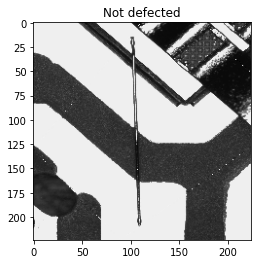

In [7]:
# make a prediction and check the result
batch_nr = np.random.choice(np.arange(0, 80))
img_nr = np.random.choice(np.arange(0, batch_size))

test_batch = test_generator[1]
print(test_batch.shape)
for i in range (batch_size):
  print(test_data.images[i])

img = test_batch[img_nr]   
print(f'Size of image: {img.shape}')
img = np.expand_dims(img, axis=0)
print(f'Changed size of image: {img.shape}')                                                             #give right image or else it will show error
predictions = loaded_model.predict(img)


# make prediction using the already trained model
label_index = np.argmax(predictions)
class_list = ['Defected' , 'Not defected']
label_class_name = class_list[label_index]

# show image and label
plt.imshow(np.squeeze(img))
plt.title(label_class_name)

In [8]:
def get_class_activation_map(model, img):
    ''' 
    this function computes the class activation map
    
    Inputs:
        1) model (tensorflow model) : trained model
        2) img (numpy array of shape (224, 224, 3)) : input image
    '''
    
    # expand dimension to fit the image to a network accepted input size
    img = np.expand_dims(img, axis=0)

    # predict to get the winning class
    predictions = model.predict(img)
    label_index = np.argmax(predictions)

    # Get the 2048 input weights to the softmax of the winning class.
    class_weights = model.layers[-4].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    
    # get the final conv layer
    final_conv_layer = model.get_layer("out_relu") #Conv_1_bn
    
    # create a function to fetch the final conv layer output maps (should be shape (1, 7, 7, 2048)) 
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    # squeeze conv map to shape image to size (7, 7, 2048)
    conv_outputs = np.squeeze(conv_outputs)

    
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1) # dim: 224 x 224 x 1280
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 1280)), class_weights_winner).reshape(224,224) # dim: 224 x 224
    
    # return class activation map
    return final_output, label_index

In [9]:
# loaded_model.summary()


In [10]:
def plot_class_activation_map(CAM, img, label_index, ax):
    ''' 
    this function plots the activation map 
    
    Inputs:
        1) CAM (numpy array of shape (224, 224)) : class activation map containing the trained heat map
        2) img (numpy array of shape (224, 224, 3)) : input image
        3) label (uint8) : index of the winning class
        4) data_path (string) : path to the images -> used to extract the class labels by extracting all local subdirs
        5) ax (matplotlib axes) : axes where current CAM should be plotted
    '''
    if(label_index==0):

      CAM2 = image.img_to_array(CAM, dtype='uint8')
      thresh = cv2.threshold(CAM2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
      # Find contours
      cnts = cv2.findContours(CAM2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = cnts[0] if len(cnts) == 2 else cnts[1]
      for c in cnts:
          x,y,w,h = cv2.boundingRect(c)
          cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

      ax.imshow(thresh)
      ax.imshow(img)
    else :
      ax.imshow(img)

    
    # get string for classified class
    class_list = ['Defected' , 'Not defected']
    label_class_name = class_list[label_index]
    ax.set_title(label_class_name)

In [11]:
def create_and_plot_6_CAMs(model, images,  batch_size):
    '''
    this function creates and plots six class activation maps
    
    Inputs:
        1) model (tensorflow model) : trained model used for the prediction and conv outputs
        2) count_CAMs (uint8) : count of activation maps that shall be plotted
        3) images (numpy array of shape (batch_size, 224, 224, 3)) : array containing the images 
        4) data_path (string) : string containing the path to the images
        5) batch_size (uint8) : number of images 
    '''
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
    
    # store axes in list for access in loop
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    
    # create random numbers for selecting the images
  
    img_nrs =  np.random.choice(np.arange(batch_size), 6, replace=False)
    print(img_nrs)
    # loop through the randomly selected image numbers and create plus plot CAM
    for index, img_index in enumerate(img_nrs):
        img = images[img_index]
        CAM, label = get_class_activation_map(model, img)
        plot_class_activation_map(CAM, img, label, axes[index])
        
    

[ 0 10  5  2 14 12]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


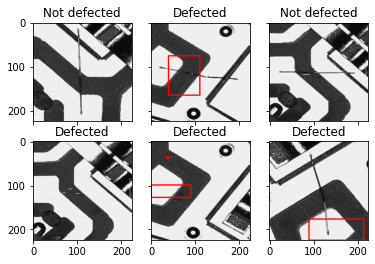

In [12]:
create_and_plot_6_CAMs(loaded_model, test_batch,  batch_size)